__Student info:__

- Student name: Thomas Brown
- Student pace: Full Time
- Scheduled project review date/time: TBD
- Instructor name: Abhineet Kulkarni
- Blog post URL: TBD

__Use Case:__<br><br>
The purpose of this project is to start building a neural network model that can determine the sentiment of financial news headlines.  The users of this model would be investment firms who want to keep track of the market sentiment of a set of various products, companies, or industries.  <br><br>
With proper web scraping and feeding of new headlines, a firm would be able to keep track of various topics to make better informed investing decisions.  For example, one could feasibly keep track of terms that are rising rapidly in terms of positive sentiment in order to invest in them.<br><br>
The data is collected from Kaggle through this [link](https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news).  It's a collection of 4,837 unique news headlines from various financial news sources. 

## Importing Libraries:

In [1]:
import pandas as pd
import numpy as np

# Scikit-Learn:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import svm
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


# Keras:
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout
from keras.utils import to_categorical
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling1D


# NLTK - Stopwords:
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet


# Sampling:
from imblearn.over_sampling import SMOTE, ADASYN

# XGBoost:
import xgboost as xgb

# Plots and Graphs:
from wordcloud import WordCloud
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import plotly.express as px
import scikitplot as skplt 
%matplotlib inline

# Other:
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
# So we can see the entire column:
pd.set_option('display.max_colwidth', -1)

Using TensorFlow backend.
/Users/Thomas/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


# Importing Data:

In [2]:
df = pd.read_csv('all-data.csv', names = ['Sentiment', 'Headline'], 
                 encoding='latin-1')
df = df.sample(frac=1).reset_index(drop=True) # Shuffling the data in case there's an ordering bias
display(df.head())
print("Shape:", df.shape, "\n\n")
print(df.info())

,Sentiment,Headline
0,neutral,Renesas Mobile Europe Ltd has approximately 470 employees in Oulu .
1,negative,Earnings per share ( EPS ) amounted to a loss of EUR0 .38 .
2,negative,11 August 2010 - Finnish measuring equipment maker Vaisala Oyj HEL : VAIAS said today that its net loss widened to EUR4 .8 m in the first half of 2010 from EUR2 .3 m in the corresponding period a year earlier .
3,positive,"Both operating profit and net sales for the three-month period increased , respectively from EUR15 .1 m and EUR131 .5 m , as compared to the corresponding period in 2005 ."
4,negative,"Finnair 's passenger load factor , which measures the number of sold seats as a share of all available seats , dropped by 1.3 percentage points to 76.7 % in September ."


Shape: (4846, 2) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
Sentiment    4846 non-null object
Headline     4846 non-null object
dtypes: object(2)
memory usage: 75.8+ KB
None


In [3]:
# Let's take a look at the number of instances of each sentiment:
df.Sentiment.value_counts()
# Not too many negatives.  This may prove to be an issue later on, but for now, let's keep moving.

neutral     2879
positive    1363
negative    604 
Name: Sentiment, dtype: int64

# Cleaning Data:

First, the labels need to be changed to numerical values in order to go through the neural network later on. Due to a low number of negative articles compared to the rest, I'll be treating this as a binary problem: 'Positive' vs 'Not Positive'.

- 0 is Negative or Neutral
- 1 is Positive

In [4]:
# BINARY
df['Sentiment'] = df['Sentiment'].map(lambda x: 1 if x == 'positive' else 0)
df.head()

,Sentiment,Headline
0,0,Renesas Mobile Europe Ltd has approximately 470 employees in Oulu .
1,0,Earnings per share ( EPS ) amounted to a loss of EUR0 .38 .
2,0,11 August 2010 - Finnish measuring equipment maker Vaisala Oyj HEL : VAIAS said today that its net loss widened to EUR4 .8 m in the first half of 2010 from EUR2 .3 m in the corresponding period a year earlier .
3,1,"Both operating profit and net sales for the three-month period increased , respectively from EUR15 .1 m and EUR131 .5 m , as compared to the corresponding period in 2005 ."
4,0,"Finnair 's passenger load factor , which measures the number of sold seats as a share of all available seats , dropped by 1.3 percentage points to 76.7 % in September ."


## Stopwords:

Next, we can remove all the 'stopwords' that can clog up the system later on.  The punctuation will get filtered out later.

In [5]:
stop = set(stopwords.words('english'))
stop.add("'s")
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

df['Headline'] = df['Headline'].map(remove_stopwords)

In [6]:
df.head()

,Sentiment,Headline
0,0,renesas mobile europe ltd approximately 470 employees oulu .
1,0,earnings per share ( eps ) amounted loss eur0 .38 .
2,0,11 august 2010 - finnish measuring equipment maker vaisala oyj hel : vaias said today net loss widened eur4 .8 first half 2010 eur2 .3 corresponding period year earlier .
3,1,"operating profit net sales three-month period increased , respectively eur15 .1 eur131 .5 , compared corresponding period 2005 ."
4,0,"finnair passenger load factor , measures number sold seats share available seats , dropped 1.3 percentage points 76.7 % september ."


## Lemmatization:

In [7]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [8]:
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    text = [wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in text.split()]
    return " ".join(text)

df['Headline'] = df['Headline'].map(lemmatize)

In [9]:
# Still looking good
df.head()

,Sentiment,Headline
0,0,renesas mobile europe ltd approximately 470 employee oulu .
1,0,earnings per share ( eps ) amount loss eur0 .38 .
2,0,11 august 2010 - finnish measure equipment maker vaisala oyj hel : vaias say today net loss widen eur4 .8 first half 2010 eur2 .3 correspond period year earlier .
3,1,"operating profit net sale three-month period increase , respectively eur15 .1 eur131 .5 , compare correspond period 2005 ."
4,0,"finnair passenger load factor , measure number sell seat share available seat , drop 1.3 percentage point 76.7 % september ."


# EDA:

Let's explore some word clouds to see the most commonly occurring words for each label.

In [10]:
# Separating out the categories
pos = df.Headline[df.Sentiment[df.Sentiment== 1].index]
neg = df.Headline[df.Sentiment[df.Sentiment== 0].index]

In [11]:
 def wordcloud(dataset):
    plt.figure(figsize = (18,24)) # Text Reviews with positive Ratings
    wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1200 , height = 800).generate(" ".join(dataset))
    plt.imshow(wordcloud,interpolation = 'bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show();

def show_wordclouds():
    print ('Positive Sentiment Wordcloud:')
    wordcloud(pos)
    ###
    print ('Negative Sentiment Wordcloud:')
    wordcloud(neg)
    ###
    

In [12]:
# Showing Word Clounds
#show_wordclouds()

Not too much useful information here.  There are some more words we can clean, but I would like to stay on the conservative side for now.

# Additional Cleaning:

As we saw above, there are a few words that are quite common that occur in all 3 labels.  We'll add this to these to the stop word list and run the headlines through the filter again:
- 'finnish'
- 'say'
- 'company'
I'm leaving in 'eur' for now as it doesn't appear heavily in the 'Neutral' category.  This may help later on.  Depending on how the neural network performs later, I may or may not activate the following cells.

In [13]:
# Taking out a few more stop words:
stop.add("finnish")
stop.add("say")
stop.add("company")

df['Headline'] = df['Headline'].map(remove_stopwords)

In [14]:
# Starting to feel a little like caveman speak, but hopefully this will be easier for the model to read!
df.head()

,Sentiment,Headline
0,0,renesas mobile europe ltd approximately 470 employee oulu .
1,0,earnings per share ( eps ) amount loss eur0 .38 .
2,0,11 august 2010 - measure equipment maker vaisala oyj hel : vaias today net loss widen eur4 .8 first half 2010 eur2 .3 correspond period year earlier .
3,1,"operating profit net sale three-month period increase , respectively eur15 .1 eur131 .5 , compare correspond period 2005 ."
4,0,"finnair passenger load factor , measure number sell seat share available seat , drop 1.3 percentage point 76.7 % september ."


In [15]:
pos = df.Headline[df.Sentiment[df.Sentiment== 1].index]
neg = df.Headline[df.Sentiment[df.Sentiment== 0].index]


In [16]:
# Showing Word Clounds with additional words removed
#show_wordclouds()

# Counter:

In [17]:
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [18]:
text = df.Headline
counter = counter_word(text)

In [19]:
len(counter)

10094

In [20]:
counter

Counter({'renesas': 2,
         'mobile': 134,
         'europe': 43,
         'ltd': 46,
         'approximately': 69,
         '470': 2,
         'employee': 84,
         'oulu': 13,
         '.': 4780,
         'earnings': 50,
         'per': 129,
         'share': 438,
         '(': 513,
         'eps': 45,
         ')': 515,
         'amount': 81,
         'loss': 160,
         'eur0': 60,
         '.38': 2,
         '11': 24,
         'august': 42,
         '2010': 238,
         '-': 303,
         'measure': 41,
         'equipment': 83,
         'maker': 80,
         'vaisala': 18,
         'oyj': 241,
         'hel': 120,
         ':': 363,
         'vaias': 3,
         'today': 149,
         'net': 413,
         'widen': 6,
         'eur4': 11,
         '.8': 23,
         'first': 193,
         'half': 57,
         'eur2': 19,
         '.3': 36,
         'correspond': 124,
         'period': 266,
         'year': 323,
         'earlier': 83,
         'operating': 299,
        

In [21]:
num_words = len(counter)

# Train/Test Split:

In [22]:
# Generating the lists of headlines and labels
headlines = []
labels = []

for row in range(len(df)):
    headlines.append(df['Headline'][row])
    labels.append(df['Sentiment'][row])

In [23]:
# Setting the training ratio
training_size = int(df.shape[0] * .8) # Out of 4846

In [24]:
# Train Test Split:
training_headlines = headlines[0:training_size]
testing_headlines = headlines[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [25]:
# Looks good
display(training_headlines[:3])
display(training_labels[:3])

['renesas mobile europe ltd approximately 470 employee oulu .',
 'earnings per share ( eps ) amount loss eur0 .38 .',
 '11 august 2010 - measure equipment maker vaisala oyj hel : vaias today net loss widen eur4 .8 first half 2010 eur2 .3 correspond period year earlier .']

[0, 0, 0]

# Tokenization:

In [26]:
vocab_size = len(counter) # approx 1/5 of the words 
embedding_dim = 32
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [27]:

# Initializing the fitting the tokenizer:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(training_headlines)
# Initializing the Word Index:
word_index = tokenizer.word_index
# Padding and Sequencing the Training Set:
training_sequences = tokenizer.texts_to_sequences(training_headlines)
training_padded = pad_sequences(training_sequences, maxlen = max_length,
                               padding = padding_type, 
                               truncating = trunc_type)
# Padding and Sequencing the Testing Set:
testing_sequences = tokenizer.texts_to_sequences(testing_headlines)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, 
                               padding = padding_type, 
                               truncating = trunc_type)


In [28]:
# Switch to Numpy Array
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [29]:
# Example of what's happening under the hood:
print ('Padded and Tokenized Headline:\n', training_padded[3])
print ('\nThe actual headline:\n', df.Headline[3])
print ('\nLabel:\n', training_labels[3])

Padded and Tokenized Headline:
 [  18   10    9    4  210   83   26   33  583 1213    5 3734   12   53
   71   26   90    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]

The actual headline:
 operating profit net sale three-month period increase , respectively eur15 .1 eur131 .5 , compare correspond period 2005 .

Label:
 1


## Taking a Look at Inputs:

In [30]:
# So far looks good:
n = 0

display(training_headlines[n])
print('-----------------')
display(training_padded[n])
print('-----------------')
display(training_labels[n])
print('-----------------')

display(testing_headlines[n])
print('-----------------')
display(testing_padded[n])
print('-----------------')
display(testing_labels[n])
print('-----------------')


'renesas mobile europe ltd approximately 470 employee oulu .'

-----------------


array([2608,   65,  266,  166,  149, 1759,  122,  866,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

-----------------


0

-----------------


'construction yit oyj november 13 , 2007 70 mln euro $ 102.8 mln contract construct new office building local property tapiola real estate oy .'

-----------------


array([  85,  330,   32,  327,  220,   31,  538,   23,   37, 5894,   38,
         23,   48, 1969,   25,  174,   91,  362,  283, 7215,  175,  390,
        117,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

-----------------


1

-----------------


In [102]:
# Making sure all our data works. . . 
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '-') for i in text])

print(decode_sentence(training_padded[1]))
print(training_headlines[1])
print(labels[1])

earnings per share eps amount loss eur0 38 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
earnings per share ( eps ) amount loss eur0 .38 .
0


# Neural Network:

In [31]:
# First let's define the functions for model evaluation
def model_eval(history):
    pd.DataFrame(history.history).plot(figsize = (8,5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  

Now it's time to build a baseline neural network:

## TEST ZONE

In [68]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GlobalAveragePooling1D())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2)) # Optional Regularization
model.add(Dense(75, activation='relu')) # Optional second hidden layer
model.add(Dropout(0.2)) # Optional Regularization
model.add(Dense(1, activation='sigmoid'))

#model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy']) # Orig code

#Messing with learning rate
opt = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy',optimizer= opt, 
              metrics=['accuracy']) # Orig code


In [69]:
num_epochs = 20
history = model.fit(training_padded, training_labels, 
                    epochs=num_epochs,
                    batch_size = 10,
                    validation_data=(testing_padded, testing_labels), 
                    verbose= 1)

Train on 3876 samples, validate on 970 samples
Epoch 1/20
3876/3876 [==============================] - 2s 639us/step - loss: 0.6303 - acc: 0.7196 - val_loss: 0.5921 - val_acc: 0.7155
Epoch 2/20
3876/3876 [==============================] - 2s 462us/step - loss: 0.5887 - acc: 0.7196 - val_loss: 0.5891 - val_acc: 0.7155
Epoch 3/20
3876/3876 [==============================] - 2s 456us/step - loss: 0.5830 - acc: 0.7196 - val_loss: 0.5866 - val_acc: 0.7155
Epoch 4/20
3876/3876 [==============================] - 2s 460us/step - loss: 0.5789 - acc: 0.7196 - val_loss: 0.5835 - val_acc: 0.7155
Epoch 5/20
3876/3876 [==============================] - 2s 454us/step - loss: 0.5721 - acc: 0.7196 - val_loss: 0.5775 - val_acc: 0.7155
Epoch 6/20
3876/3876 [==============================] - 2s 461us/step - loss: 0.5570 - acc: 0.7196 - val_loss: 0.5642 - val_acc: 0.7155
Epoch 7/20
3876/3876 [==============================] - 2s 470us/step - loss: 0.5279 - acc: 0.7327 - val_loss: 0.5451 - val_acc: 0.7299
E

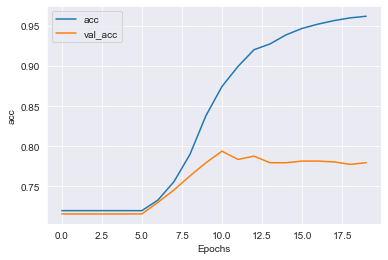

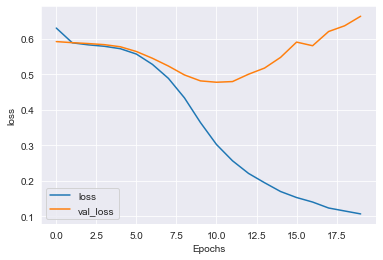

In [70]:
model_eval(history)
plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [75]:
sentence = ["Stock rise rapid for Tesla", 
            "Apple factory shut down, lay off hundred employee",
           "Average day of return for Microsoft"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, 
                       padding=padding_type, 
                       truncating=trunc_type)
print(model.predict(padded))

[[0.953247  ]
 [0.00303712]
 [0.30974004]]


In [36]:
print break_

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(break_)? (<ipython-input-36-8dc0057c2caf>, line 1)

### LSTM Test:

In [52]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(LSTM(64, dropout = 0.1))
model.add(Dense(35, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy']) # Orig code

In [53]:
num_epochs = 15
history = model.fit(training_padded, training_labels, 
                    epochs=num_epochs,
                    batch_size = 24,
                    validation_data=(testing_padded, testing_labels), 
                    verbose= 1)

Train on 3876 samples, validate on 970 samples
Epoch 1/15
3876/3876 [==============================] - 11s 3ms/step - loss: 0.6015 - acc: 0.7185 - val_loss: 0.5972 - val_acc: 0.7155
Epoch 2/15
3876/3876 [==============================] - 10s 3ms/step - loss: 0.5948 - acc: 0.7196 - val_loss: 0.6065 - val_acc: 0.7155
Epoch 3/15
3876/3876 [==============================] - 10s 3ms/step - loss: 0.5908 - acc: 0.7193 - val_loss: 0.6444 - val_acc: 0.7155
Epoch 4/15
3876/3876 [==============================] - 11s 3ms/step - loss: 0.5808 - acc: 0.7232 - val_loss: 0.5642 - val_acc: 0.7155
Epoch 5/15
3876/3876 [==============================] - 11s 3ms/step - loss: 0.5551 - acc: 0.7500 - val_loss: 0.5679 - val_acc: 0.7433
Epoch 6/15
3876/3876 [==============================] - 11s 3ms/step - loss: 0.5620 - acc: 0.7510 - val_loss: 0.5741 - val_acc: 0.7381
Epoch 7/15
3876/3876 [==============================] - 11s 3ms/step - loss: 0.5551 - acc: 0.7570 - val_loss: 0.5656 - val_acc: 0.7454
Epoch 8/

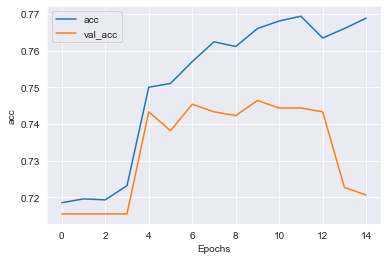

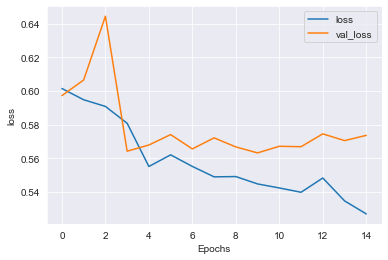

In [54]:
plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [72]:
sentence = ["Stocks rise rapidly for Tesla", 
            "Apple factory shuts down",
           "Average day of returns for Microsoft"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, 
                       padding=padding_type, 
                       truncating=trunc_type)
print(model.predict(padded))

[[0.8410685 ]
 [0.07090827]
 [0.07887366]]


In [56]:
sentence = ["Former Nissan Executive Greg Kelly Pleads Not Guilty at Tokyo Trial", 
            "Amazon to Hire 100,000 in U.S. and Canada",
           "Disney’s ‘Mulan’ Tops China Box Office Amid Controversy"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, 
                       padding=padding_type, 
                       truncating=trunc_type)
print(model.predict(padded))

[[0.17934008]
 [0.17934011]
 [0.17934008]]


## End TEST ZONE:

## Baseline Model:

In [87]:
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dropout(0.2), # Optional Regularization
    keras.layers.Dense(50, activation='relu'), # Optional second hidden layer
    keras.layers.Dropout(0.2), # Optional Regularization
    keras.layers.Dense(1, activation='sigmoid')])

opt = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy',optimizer = opt, metrics=['accuracy']) # Orig code


In [88]:
#model.summary()

In [89]:
num_epochs = 50
history = model.fit(training_padded, training_labels, 
                    epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels), 
                    verbose= 2)

Train on 3876 samples, validate on 970 samples
Epoch 1/50
 - 1s - loss: 0.6750 - acc: 0.7165 - val_loss: 0.6581 - val_acc: 0.7155
Epoch 2/50
 - 1s - loss: 0.6390 - acc: 0.7196 - val_loss: 0.6185 - val_acc: 0.7155
Epoch 3/50
 - 1s - loss: 0.6030 - acc: 0.7196 - val_loss: 0.5940 - val_acc: 0.7155
Epoch 4/50
 - 1s - loss: 0.5898 - acc: 0.7196 - val_loss: 0.5898 - val_acc: 0.7155
Epoch 5/50
 - 1s - loss: 0.5863 - acc: 0.7196 - val_loss: 0.5884 - val_acc: 0.7155
Epoch 6/50
 - 1s - loss: 0.5834 - acc: 0.7196 - val_loss: 0.5871 - val_acc: 0.7155
Epoch 7/50
 - 1s - loss: 0.5814 - acc: 0.7196 - val_loss: 0.5857 - val_acc: 0.7155
Epoch 8/50
 - 1s - loss: 0.5784 - acc: 0.7196 - val_loss: 0.5841 - val_acc: 0.7155
Epoch 9/50
 - 1s - loss: 0.5785 - acc: 0.7196 - val_loss: 0.5820 - val_acc: 0.7155
Epoch 10/50
 - 1s - loss: 0.5703 - acc: 0.7196 - val_loss: 0.5796 - val_acc: 0.7155
Epoch 11/50
 - 1s - loss: 0.5662 - acc: 0.7196 - val_loss: 0.5761 - val_acc: 0.7155
Epoch 12/50
 - 1s - loss: 0.5603 - acc

### Model Evaluation:

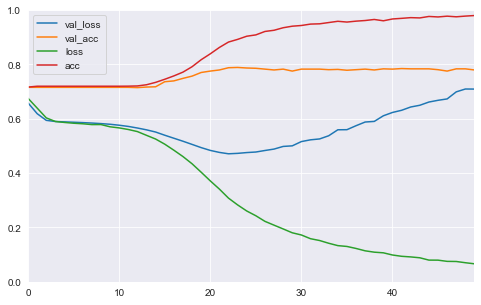

In [90]:
model_eval(history)

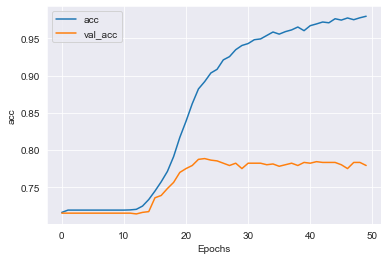

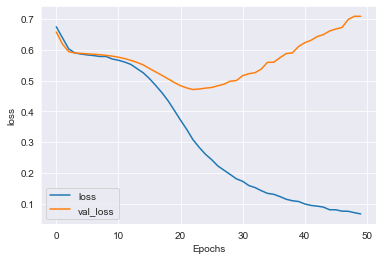

In [91]:
plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [92]:
# Testing Made Up Headlines:
sentence = ["Stock rise rapid for Tesla", 
            "Apple factory shut down",
           "Average day of return for Microsoft"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, 
                       padding=padding_type, 
                       truncating=trunc_type)
print(model.predict(padded))

[[0.9763974]
 [0.0281518]
 [0.4114216]]


## Neural Network with Transfer Learning:

In [ ]:
#nltk.download('vader_lexicon')
#from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
sid.polarity_scores('The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .')

In [ ]:
sid.polarity_scores('tesla stocks rise rapidly')

In [ ]:
#from textblob import TextBlob
headline1 = "tesla lays off all employees"
headline2 = 'the food at Radison was very good'
blob1 = TextBlob(headline1)
blob2 = TextBlob(headline2)
print(blob1.polarity)
print(blob2.polarity)

In [ ]:
df2 = df

In [ ]:
threshold = .1

for headline in df2['Headline']:
#    df2['tb_sent'] = (TextBlob(headline).polarity)
    df2['tb_sent'][headline] = (TextBlob(headline).polarity)
    
#for item in df['tb_sent']:
#    if item > threshold:
#        item = 1
#    else:
#        item = 0

In [ ]:
df2.tail()

### Model Evaluation:

# Other:

In [ ]:
print break_

In [93]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10094, 32)


In [96]:
'''
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()
'''

'\nimport io\n\nout_v = io.open(\'vecs.tsv\', \'w\', encoding=\'utf-8\')\nout_m = io.open(\'meta.tsv\', \'w\', encoding=\'utf-8\')\nfor word_num in range(1, vocab_size):\n  word = reverse_word_index[word_num]\n  embeddings = weights[word_num]\n  out_m.write(word + "\n")\n  out_v.write(\'\t\'.join([str(x) for x in embeddings]) + "\n")\nout_v.close()\nout_m.close()\n'

In [97]:
# Testing Made Up Headlines:
sentence = ["Stock rise rapid for Tesla", 
            "Apple factory shut down",
           "Average day of return for Microsoft"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, 
                       padding=padding_type, 
                       truncating=trunc_type)
print(model.predict(padded))

[[0.9763974]
 [0.0281518]
 [0.4114216]]


In [99]:
# Testing Real Headlines - Source - Bloomberg:
sentence = ["Ray Dalio Warn of Threat to Dollar as Reserve Currency", 
            "FTC Prepare Possible Antitrust Lawsuit Against Facebook",
           "Trump Say He Want a 4 Hour Debate Moderate by Joe Rogan"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, 
                       padding=padding_type, 
                       truncating=trunc_type)
print(model.predict(padded))

[[0.00054475]
 [0.01653454]
 [0.37644133]]


# Further Work:

In the future, I'd like to complete the following analysis:
- A web application that collects and analyzes headlines from various financial news sources.
- Other neural network architecture types.
- New types of sentiment analysis, such as breaking news vs an opinion piece on an older issue.
- Rate different newspapers by sentiment value.

# Conclusion: